In [ ]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2

2024-04-12 12:59:13.177536: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 25363087360


# Poincare Disk
> Witty encapsulation

**Hypothesis**: Stuff will happen

# Machinery

In [ ]:
def add_hexagon_nodes(graph, center_id, start_id, depth):
    """
    Recursively add nodes to the graph to form a hexagonal tiling.

    :param graph: The graph represented as a dictionary.
    :param center_id: The ID of the current center node.
    :param start_id: The ID to start assigning to new nodes.
    :param depth: The current depth of the recursion.
    :return: The next unused node ID.
    """
    if depth == 0:
        return start_id

    # IDs of the nodes in the current hexagon layer
    hexagon_ids = []
    for i in range(6):
        hexagon_ids.append(start_id + i)
        graph[start_id + i] = []

    # Connect the hexagon nodes to the center node and each other
    for i, node_id in enumerate(hexagon_ids):
        graph[center_id].append(node_id)
        graph[node_id].append(center_id)  # Connect back to the center node
        # Connect to the next node in the hexagon
        next_node_id = hexagon_ids[(i + 1) % 6]
        graph[node_id].append(next_node_id)
        graph[next_node_id].append(node_id)  # Connect back to the current node

    # Recursively add nodes for each node in the current hexagon
    next_start_id = start_id + 6
    for node_id in hexagon_ids:
        next_start_id = add_hexagon_nodes(graph, node_id, next_start_id, depth - 1)

    return next_start_id

def create_hexagonal_tiling_graph(depth):
    """
    Create a graph from a hexagonal tiling of the Poincaré disk.

    :param depth: The depth of the hexagonal tiling.
    :return: The graph represented as a dictionary.
    """
    graph = {0: []}  # Start with the central node
    add_hexagon_nodes(graph, 0, 1, depth)
    return graph

# Example usage
depth = 2  # Adjust the depth as needed
graph = create_hexagonal_tiling_graph(depth)
print(graph)

{0: [1, 2, 3, 4, 5, 6], 1: [0, 2, 6, 7, 8, 9, 10, 11, 12], 2: [1, 0, 3, 13, 14, 15, 16, 17, 18], 3: [2, 0, 4, 19, 20, 21, 22, 23, 24], 4: [3, 0, 5, 25, 26, 27, 28, 29, 30], 5: [4, 0, 6, 31, 32, 33, 34, 35, 36], 6: [5, 0, 1, 37, 38, 39, 40, 41, 42], 7: [1, 8, 12], 8: [7, 1, 9], 9: [8, 1, 10], 10: [9, 1, 11], 11: [10, 1, 12], 12: [11, 1, 7], 13: [2, 14, 18], 14: [13, 2, 15], 15: [14, 2, 16], 16: [15, 2, 17], 17: [16, 2, 18], 18: [17, 2, 13], 19: [3, 20, 24], 20: [19, 3, 21], 21: [20, 3, 22], 22: [21, 3, 23], 23: [22, 3, 24], 24: [23, 3, 19], 25: [4, 26, 30], 26: [25, 4, 27], 27: [26, 4, 28], 28: [27, 4, 29], 29: [28, 4, 30], 30: [29, 4, 25], 31: [5, 32, 36], 32: [31, 5, 33], 33: [32, 5, 34], 34: [33, 5, 35], 35: [34, 5, 36], 36: [35, 5, 31], 37: [6, 38, 42], 38: [37, 6, 39], 39: [38, 6, 40], 40: [39, 6, 41], 41: [40, 6, 42], 42: [41, 6, 37]}


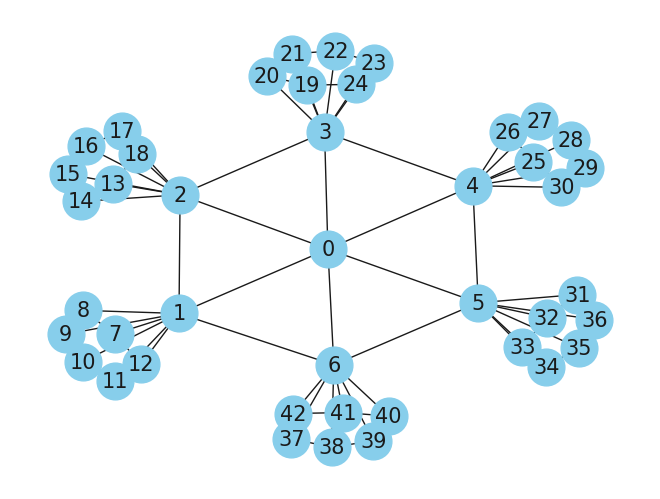

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def graph_to_adjacency_matrix(graph):
    """
    Convert a graph represented as a dictionary to a dense adjacency matrix.

    :param graph: The graph represented as a dictionary.
    :return: A NumPy array representing the adjacency matrix.
    """
    n = len(graph)
    adjacency_matrix = np.zeros((n, n), dtype=int)
    for node, neighbors in graph.items():
        for neighbor in neighbors:
            adjacency_matrix[node, neighbor] = 1
    return adjacency_matrix

def draw_graph_from_adjacency_matrix(adjacency_matrix):
    """
    Draw a graph given its adjacency matrix using networkx.

    :param adjacency_matrix: A NumPy array representing the adjacency matrix.
    """
    G = nx.from_numpy_array(adjacency_matrix)
    pos = nx.spring_layout(G)  # For better visualization, try different layouts
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='k', linewidths=1, font_size=15)
    plt.show()

# Assuming the create_hexagonal_tiling_graph function is defined as before
depth = 2  # Adjust the depth as needed
graph = create_hexagonal_tiling_graph(depth)

# Convert the graph to an adjacency matrix and draw it
adjacency_matrix = graph_to_adjacency_matrix(graph)
draw_graph_from_adjacency_matrix(adjacency_matrix)


In [ ]:
adjacency_matrix.shape

(43, 43)

In [ ]:
def initialize_graph():
    """
    Initialize the graph with the center node and its immediate children.
    """
    graph = {0: [1, 2, 3, 4, 5, 6]}  # Center node connected to its six children
    for i in range(1, 7):
        graph[i] = [0]  # Connect each child back to the center
    return graph, 7  # Return the initialized graph and the next node ID

def connect_nodes(graph, node1, node2):
    """
    Connect two nodes in the graph.
    """
    if node2 not in graph[node1]:
        graph[node1].append(node2)
    if node1 not in graph[node2]:
        graph[node2].append(node1)

def add_layer(graph, start_id, depth, max_depth):
    """
    Add a layer of nodes to the graph.
    """
    if depth == max_depth:
        return start_id

    # Number of nodes in the current layer
    num_nodes_in_layer = 6 * depth
    next_start_id = start_id + num_nodes_in_layer
    new_nodes = list(range(start_id, next_start_id))

    # Initialize new nodes in the graph
    for node in new_nodes:
        graph[node] = []

    # Connect the new nodes to form a hexagon and connect to the parent nodes
    for i in range(num_nodes_in_layer):
        # Connect to the next node in the hexagon
        next_node = new_nodes[(i + 1) % num_nodes_in_layer]
        connect_nodes(graph, new_nodes[i], next_node)

        # Connect to the parent node
        parent_node = (i // 3) + ((depth - 1) * 6 - 5)
        connect_nodes(graph, new_nodes[i], parent_node)

        # Connect to the child nodes (if not the last layer)
        if depth < max_depth - 1:
            child_start_id = next_start_id + (i * 3)
            for j in range(3):
                if child_start_id + j not in graph:
                    graph[child_start_id + j] = []
                connect_nodes(graph, new_nodes[i], child_start_id + j)

    # Connect the outer children of adjacent parent nodes
    if depth < max_depth - 1:
        for i in range(num_nodes_in_layer):
            # Find the outer child and the corresponding outer child of the next parent
            if i % 3 == 2:  # Outer child
                outer_child_id = next_start_id + (i * 3) + 2
                next_outer_child_id = next_start_id + (((i + 3) % num_nodes_in_layer) * 3)
                connect_nodes(graph, outer_child_id, next_outer_child_id)

    return next_start_id

def create_hexagonal_tiling_graph(max_depth):
    """
    Create a graph from a hexagonal tiling of the Poincaré disk.
    """
    graph, next_node_id = initialize_graph()
    for depth in range(1, max_depth):
        next_node_id = add_layer(graph, next_node_id, depth, max_depth)
    return graph

# Example usage
max_depth = 3  # Adjust the depth as needed
graph = create_hexagonal_tiling_graph(max_depth)
print(graph)

# Assuming the graph_to_adjacency_matrix and draw_graph_from_adjacency_matrix functions are defined as before
adjacency_matrix = graph_to_adjacency_matrix(graph)
draw_graph_from_adjacency_matrix(adjacency_matrix)


KeyError: -5

# Results

# Conclusion